## Issuance of a PRC as QR code

In [1]:
# Load the private key from the PEM file
with open('private_key_ec.pem', 'rb') as f:
    private_key_pem = f.read()

In [2]:
# Compute fingerprint of private key
from helper import get_ec_private_key_fingerprint
fingerprint = get_ec_private_key_fingerprint(private_key_pem)
print("Hex-encoded fingerprint:", fingerprint)

Hex-encoded fingerprint: 3e47b334052d2575f1943c8af41026580810f88c30a236db0ef19bdd8a5d92a2


### EHIC data sample

In [3]:
sample_ehic_data = {
    "ic": "BE",
    "hn": {
        "fn": "Clément-Lafarge",
        "gn": "Jean-Pierre, Frédéric",
    },
    "dob": "29-02-2000",
    "hi": "0001019999",
    "ii": "0216X",
    "in": "LAMUTUALITENEUTRE",
    "ci": "021XXXXXXX2023035407",
    "sd": "28-02-2023",
    "ed": "29-02-2024",
    "id": "31-01-2024"
}
print("Approx. byte size:", len(str(sample_ehic_data)))

Approx. byte size: 249


### Create payload of verifiable credential
The credentialSubject is the actual EHIC data sample

In [4]:
verifiable_credential = {
    "@context": [
        "https://www.w3.org/2018/credentials/v1",
        "https://w3id.org/vc/status-list/2021/v1"
    ],
    "type": [
        "VerifiableCredential",
        "EHICCredential"
    ],
    "credentialSubject": sample_ehic_data,
    "credentialSchema": {
        "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
        "type": "FullJsonSchemaValidator2021"
    }
}
print("Approx. byte size:", len(str(verifiable_credential)))

Approx. byte size: 622


### Build JSON web token

In [5]:
import datetime
import json

# Define the content of the JWT
payload = {
    "iat": int(datetime.datetime.now().timestamp()),  # Issued at
    "nbf": int(datetime.datetime.now().timestamp()),  # Not before
    "exp": int((datetime.datetime.now() + datetime.timedelta(days=365)).timestamp()), # Expiration date
    "vc": verifiable_credential,
    "kid": fingerprint, # Key identifier
    "iss": f"ESSI:BE:0100", # Issuer
}

print(json.dumps(payload, indent=4))
print("Approx. byte size:", len(str(payload)))

{
    "iat": 1741264358,
    "nbf": 1741264358,
    "exp": 1772800358,
    "vc": {
        "@context": [
            "https://www.w3.org/2018/credentials/v1",
            "https://w3id.org/vc/status-list/2021/v1"
        ],
        "type": [
            "VerifiableCredential",
            "EHICCredential"
        ],
        "credentialSubject": {
            "ic": "BE",
            "hn": {
                "fn": "Cl\u00e9ment-Lafarge",
                "gn": "Jean-Pierre, Fr\u00e9d\u00e9ric"
            },
            "dob": "29-02-2000",
            "hi": "0001019999",
            "ii": "0216X",
            "in": "LAMUTUALITENEUTRE",
            "ci": "021XXXXXXX2023035407",
            "sd": "28-02-2023",
            "ed": "29-02-2024",
            "id": "31-01-2024"
        },
        "credentialSchema": {
            "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
            "type": "FullJsonSc

### Sign JWT

In [6]:
import jwt

encoded_jws = jwt.encode(payload, private_key_pem, algorithm='ES256')
print("Encoded JWS (JWT):", encoded_jws)
print("Approx. byte size:", len(encoded_jws))

Encoded JWS (JWT): eyJhbGciOiJFUzI1NiIsInR5cCI6IkpXVCJ9.eyJpYXQiOjE3NDEyNjQzNTgsIm5iZiI6MTc0MTI2NDM1OCwiZXhwIjoxNzcyODAwMzU4LCJ2YyI6eyJAY29udGV4dCI6WyJodHRwczovL3d3dy53My5vcmcvMjAxOC9jcmVkZW50aWFscy92MSIsImh0dHBzOi8vdzNpZC5vcmcvdmMvc3RhdHVzLWxpc3QvMjAyMS92MSJdLCJ0eXBlIjpbIlZlcmlmaWFibGVDcmVkZW50aWFsIiwiRUhJQ0NyZWRlbnRpYWwiXSwiY3JlZGVudGlhbFN1YmplY3QiOnsiaWMiOiJCRSIsImhuIjp7ImZuIjoiQ2xcdTAwZTltZW50LUxhZmFyZ2UiLCJnbiI6IkplYW4tUGllcnJlLCBGclx1MDBlOWRcdTAwZTlyaWMifSwiZG9iIjoiMjktMDItMjAwMCIsImhpIjoiMDAwMTAxOTk5OSIsImlpIjoiMDIxNlgiLCJpbiI6IkxBTVVUVUFMSVRFTkVVVFJFIiwiY2kiOiIwMjFYWFhYWFhYMjAyMzAzNTQwNyIsInNkIjoiMjgtMDItMjAyMyIsImVkIjoiMjktMDItMjAyNCIsImlkIjoiMzEtMDEtMjAyNCJ9LCJjcmVkZW50aWFsU2NoZW1hIjp7ImlkIjoiaHR0cHM6Ly9hcGktcGlsb3QuZWJzaS5ldS90cnVzdGVkLXNjaGVtYXMtcmVnaXN0cnkvdjMvc2NoZW1hcy8weGZhODk5ZmQyYmMyYTVhNjZhZDUxZjk4ODE4MTM0MDFlYmUwMmY3ZGQ0MGIwOTI2YzNlNDljOTUxNGE3N2NiNmEiLCJ0eXBlIjoiRnVsbEpzb25TY2hlbWFWYWxpZGF0b3IyMDIxIn19LCJraWQiOiIzZTQ3YjMzNDA1MmQyNTc1ZjE5NDNjOGFmNDEwMjY1ODA4MTBmODhj

### Generate QR code

Compress encoded JWS using ZLib

In [7]:
import zlib
import base64

# Compress the JWS using zlib
compressed_jws = zlib.compress(encoded_jws.encode('utf-8'))

compressed_jws_b64 = base64.b64encode(compressed_jws).decode('utf-8')
print("Compressed JWS (base64):", compressed_jws_b64)
print("Approx. byte size:", len(compressed_jws))

Compressed JWS (base64): eJxdk1uTojoUhf/RFBdx2kflZjgmDAjB5OWUhD4mEJBuVAi/foL21MycB4qqDXuvL2uvvKuIlyETsYiCfAYmEmAAXeowF6xB05+wG22+vauoJ6dExLVvI89XqE5mlF0G0DqCCrCGGTNgBizkQTN2R0FPfAT1dUIzU7G3HeGcrw5uZBEF1nrWllibexXiVaVFChVdq306svn6ONiVXSnHhsp5sJY9YL2dYndTsxY3tHCMcxEMTG0seNSQLTeq/W6OxdujmlFP3VdP1cIHs1Ne7fF8KKae2ckyR8Hj0hdVmsN4P+0kqPsSSCpZK1s9V5Qh9v7UAWIUac6jxECKFqksu7QnxShOx1EQO5I0xPoMkpcBMknbS2Jrf7pBnAu4mOmmL8a71vkOWqrfV5FYE6uy7UgzeVt0DvnEaRsoauVCc3WleJouSbG65aGUrIvkwd2FTE4m9HYyLtJf/WrR+U+z0HAjltmwbm7QAzd91hG6T+3+WV/8z7SPWePETyb5VQcTkpdFt3/pTrsM4xznATziNMgajHEQBYsPxGr0mcAI64AUAX8+T0/nrc5BMiK1hAY1L47LLw4Fl7r29H98Cj355Ks++7ruf9Wjjeb5a9+5ha60MPnLx1fPeZ8abA/XB7XhLGxuLJRDaSd3WkTz+ejI6rgxWIdnnbHmcEL1OcQ3coI3Pbc7n5D+1jyqWufkazZTb+N7SHnsNQ5tE0VaqEiGOaopp14+0bpZxZ6/ghk0oBdI0uYjbIlNw8SAIRhjnX0yI4k8WcdZPqFQ3xMLCdT64nferiLt8FD6/VxaTkYsLssiKIjOKA0Do7SBWnYCOnPx4PNcJIvnM80Sm9RwRt7WhJoNZcykte8gD9VxGLT6Puq9EFPfM823a2OP6793HNbQopqNFmSKi6ihHueoSBzY+mrZqfZhfjJhlB2z3k2z65KTEXTGtzdCds2Png8fSP4TfKQdutz+/cwudxO

Encode the compressed data using Base45

In [8]:
import base45

base45_encoded = base45.b45encode(compressed_jws)
print("Base45 encoded JWS:", base45_encoded)
print("Approx. byte size:", len(base45_encoded))

Base45 encoded JWS: b'6BFF$B/PB+MKXQ2EFWDO2VHE049N-CK 4 417.S+YIP%7A42T.DY41V:F89V0*P+.0IMLSSFY:5X9M$ULY4J1M2QBHPUFQ 466CC*BQ36.YL+XQ%BME*D0:NRBLP6L2*OB2EO9QLCLP/C9YBQEQZJGAEMG83C6CHU5-A8*.EOB8NUFH1VRG85QAW6NLNS*5M0/D$6265RY5R39B9PFQRS9+KGC1*$BI$F7SMLSV5HR:YB3AP%QPQEM7Y7V/N7KC7QAH 2M M0YH:62ZT9:R5B*QAW5XRL./DQ0PWUKPCA8:R74A NO7UM10CZNUB65U3KQJP9392 SX.2JPJ39F3:TEGL0E2-F5TL5/X7VWI5AV3 Q/HC-GDTVK778-%2LT5*YMR-O7/97BA+N78U6MRV.NI 607F9%N9OQDQONWWJ6FN9OTZ16QXN%LVZKBPAS%GI+L2+RMX59HFFAUE+PV.CD-45A:S$QEF-K5MJAE9ASN9JKQ LG-S90S4T9R-4I.EG-536CUMDDNV.WM.7E73JVDMI0EDI0*+F%A2V4A/6W26CRBQM5IXZSC0AJNVB+0.NIR 8U7G+.9ES1JT3170%QSGDP/XH6124QHH$OM-UKCOXYT N2*3G81A:CTG3Q9F6S.MEZ0O06+UPYY178J+9VB5GBD1RQV8TL2$VZ6UG0RB.H-NVXCSM+G3ZM2QV19PDAQ55KXTDC8RV:MWR5Y-DKXI9DD:3FBW8VQV:HP%CNS8BK4D2MMS8E20VB OJLEB:6H7NX7KX9W5U76MBK*S2*6N6EFQFRIF$V6NZDOY8FCLQ/G1NL67LG.75PNA:OL9OH83XAKC99A4TKWDH$9*$OC84VQCA$F7M4ES739PD-73AAFI2-A1BWV-6FS0MR3UUAAF1WXIB9*89-5EE4CDH%25VK0* MSJBUC0QTEWJS8TB+UHVO6%F2O%Q7/8G5RHLJ5*C0$KGAU302HDE

Generate QR code

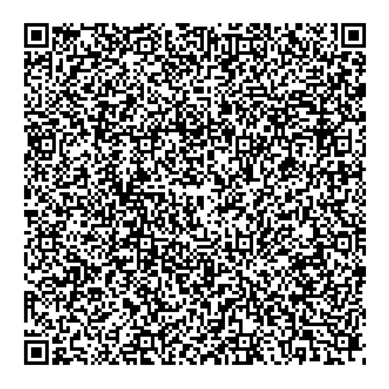

In [9]:
import qrcode
import matplotlib.pyplot as plt

# Create a QR code instance
qr = qrcode.QRCode(
    version=1,  # Controls the size of the QR Code
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)

qr.add_data(base45_encoded)
qr.make(fit=True)

# Create an image from the QR code instance
img = qr.make_image(fill='black', back_color='white')
img.save("qrcode.png")


# Display the image in the notebook
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

### Make a PDF

In [10]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader


# Create a canvas object
c = canvas.Canvas("prc.pdf", pagesize=A4)
width, height = A4

# Set font and size for the text
c.setFont("Helvetica", 12)

# Add text element of EHIC data
i = 0
for key, value in sample_ehic_data.items():
    i += 1
    c.drawString(100, height - 100 - 20 * i, f'{key}: {value}')

# Add QR code to PDF
y_position = height - 320 - 20 * i
img = ImageReader("qrcode.png")
c.drawImage(img, 100, y_position, width=200, height=200, mask='auto')

# Save the PDF file
c.save()